# Procesamiento de datos para las bases del estudio cuantitativo

# Tabla de contenidos

<a id ='Ir a inicio'></a>

<a href='#base'> Cargar base de datos </a>

<a href='#Procesamiento de bases de datos'> Procesamiento de las bases de datos </a>

<a href='#descriptivos'> Estadísticos descriptivos </a>


<a href='#Analisis entre pruebas'> Análisis entre pruebas </a>


En caso de que queramos descargar alguna de las bases de datos que se han generado, podemos bajarlas por medio del código de abajo:

In [ ]:
# csv_download_link(scalerpd, 'rescaled_newX.csv') 

_____________________

In [657]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from scipy import stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
from bioinfokit.analys import stat
import csv
import pingouin as pg
from sklearn.preprocessing import Normalizer
import matplotlib.ticker as mtick
from sklearn.preprocessing import MinMaxScaler

In [511]:
def sem(sd, n):
    se = sd /np.sqrt(n)
    return se

def ci95 (mean, sem, z=1.960):
    low = mean - z*sem
    high = mean + z*sem
    return [low, high]

#for dataset

def ci951 (data, z=1.960):
    sem1 = np.nanstd(data)/np.sqrt(len(data))
    mean = np.nanmean(data)
    low = mean - z*sem1
    high = mean + z*sem1
    return [low, high]
    
def sex_groups(series):
    if series == 2.0:
        return "Niña"
    elif series == 1.0:
        return "Niño"
    
def csv_download_link(df, csv_file_name, delete_prompt=True):
    """Display a download link to load a data frame as csv from within a Jupyter notebook"""
    df.to_csv(csv_file_name, index=False)
    from IPython.display import FileLink
    display(FileLink(csv_file_name))
    if delete_prompt:
        a = input('Press enter to delete the file after you have downloaded it.')
        import os
        os.remove(csv_file_name)
    
#usando la documentación, rescato estas funcoines:   

def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha


def percentage_of_area_under_std_normal_curve_from_zcore(z_score):
    return .5 * (math.erf(z_score / 2 ** .5) + 1)

def calculate_kmo(x):
    """
    Calculate the Kaiser-Meyer-Olkin criterion
    for items and overall. This statistic represents
    the degree to which each observed variable is
    predicted, without error, by the other variables
    in the dataset. In general, a KMO < 0.6 is considered
    inadequate.

    Parameters
    ----------
    x : array-like
        The array from which to calculate KMOs.

    Returns
    -------
    kmo_per_variable : numpy array
        The KMO score per item.
    kmo_total : float
        The KMO score overall.
    """

    # calculate the partial correlations
    partial_corr = partial_correlations(x)

    # calcualte the pair-wise correlations
    x_corr = corr(x)

    # fill matrix diagonals with zeros
    # and square all elements
    np.fill_diagonal(x_corr, 0)
    np.fill_diagonal(partial_corr, 0)

    partial_corr = partial_corr**2
    x_corr = x_corr**2

    # calculate KMO per item
    partial_corr_sum = np.sum(partial_corr, axis=0)
    corr_sum = np.sum(x_corr, axis=0)
    kmo_per_item = corr_sum / (corr_sum + partial_corr_sum)

    # calculate KMO overall
    corr_sum_total = np.sum(x_corr)
    partial_corr_sum_total = np.sum(partial_corr)
    kmo_total = corr_sum_total / (corr_sum_total + partial_corr_sum_total)
    return kmo_per_item, kmo_total


def calculate_bartlett_sphericity(x):
    """
    Test the hypothesis that the correlation matrix
    is equal to the identity matrix.identity

    H0: The matrix of population correlations is equal to I.
    H1: The matrix of population correlations is not equal to I.

    The formula for Bartlett's Sphericity test is:

    .. math:: -1 * (n - 1 - ((2p + 5) / 6)) * ln(det(R))

    Where R det(R) is the determinant of the correlation matrix,
    and p is the number of variables.

    Parameters
    ----------
    x : array-like
        The array from which to calculate sphericity.

    Returns
    -------
    statistic : float
        The chi-square value.
    p_value : float
        The associated p-value for the test.
    """
    n, p = x.shape
    x_corr = corr(x)

    corr_det = np.linalg.det(x_corr)
    statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
    degrees_of_freedom = p * (p - 1) / 2
    p_value = chi2.sf(statistic, degrees_of_freedom)
    return statistic, p_value

______________

<a id ='base'></a>

# Cargar base de datos

Cargo la base de datos que se encuentra guardada en la carpeta. 

A esta base la limpio de la siguiente manera: 

(1) Los valores perdidos o NaN, no me interesan porque no impiden que pueda anañizar la base, así que no los manipulo. 


(2) Elimino los espacios o líneas adicionales usando la función de 'replace', pues esto me permite converir mis datos de 'string' a 'numeric'. 

(3) Separo la base por Sexo (en caso de que sea necesario). 

In [103]:
df = pd.read_csv('pochito.csv', sep = ",", encoding = 'Latin-1')

In [239]:
df.head()

,Progreso,Duracion,Termina,Colegio,Sexo,Edad,Curso,Codigo,MCGM_1,MCGM_2,...,PANAS.20,PANAS.21,PANAS.22,EDESI,EDESI.1,EDESI.2,EDESI.3,EDESI.4,EDESI.5,EDESI.6
0,100.0,1177.0,True,1.0,1.0,11.0,6.0,8180360.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100.0,2407.0,True,1.0,1.0,11.0,6.0,8210064.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100.0,1623.0,True,1.0,1.0,9.0,4.0,8210473.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100.0,1111.0,True,1.0,1.0,9.0,4.0,8170350.0,5.0,5.0,...,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
4,100.0,1225.0,True,1.0,1.0,9.0,4.0,8170243.0,5.0,4.0,...,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0


In [105]:
#Elimino espacios entre las celdas
table = df.replace(r'\n',  '', regex=True)

<a id = 'Procesamiento de bases de datos'></a>

In [106]:
table.head()

,Progreso,Duracion,Termina,Colegio,Sexo,Edad,Curso,Codigo,MCGM_1,MCGM_2,...,PANAS.20,PANAS.21,PANAS.22,EDESI,EDESI.1,EDESI.2,EDESI.3,EDESI.4,EDESI.5,EDESI.6
0,100.0,1177.0,True,1.0,1.0,11.0,6.0,8180360.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100.0,2407.0,True,1.0,1.0,11.0,6.0,8210064.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100.0,1623.0,True,1.0,1.0,9.0,4.0,8210473.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100.0,1111.0,True,1.0,1.0,9.0,4.0,8170350.0,5.0,5.0,...,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
4,100.0,1225.0,True,1.0,1.0,9.0,4.0,8170243.0,5.0,4.0,...,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0


In [252]:
niño = table.loc[table['Sexo'] == 1.0]
niña = table.loc[table['Sexo'] == 2.0]

__________

# Preprocesamiento y limpieza de las bases

1 Comenzamos por organizar el OROS GRAT, OROS EP y MCGM  de acuerdo a sus respectivas subescalas. 

Separo las subescalas de la base de datos

Reescalar ítems a 1-5 en caso de ser necesario

Esto es para el MCGM

In [451]:
MCGM = table[['MCGM_1', 'MCGM_2', 'MCGM_3', 'MCGM_4','MCGM_5','MCGM_6',
            'MCGM_8','MCGM_9','MCGM_10','MCGM_11','MCGM_12','MCGM_13','MCGM_14','MCGM_15',
            'MCGM_17','MCGM_18','MCGM_19','MCGM_20','MCGM_21','MCGM_22',
            'MCGM_23','MCGM_24','MCGM_25','MCGM_26','MCGM_27','MCGM_28','MCGM_29']]
MCGM = MCGM[0:324]

In [453]:
array = MCGM.values
array

array([[5., 5., 5., ..., 7., 7., 7.],
       [5., 5., 5., ..., 7., 7., 7.],
       [4., 5., 4., ..., 2., 2., 2.],
       ...,
       [5., 5., 5., ..., 7., 7., 7.],
       [4., 5., 5., ..., 7., 7., 6.],
       [5., 5., 5., ..., 6., 7., 7.]])

In [454]:
# separate array into input and output components
X = array[:,0:29]
Y = array[:,26]

In [455]:
scaler = MinMaxScaler(feature_range=(1, 5))
#transformar los datos
rescaledX = scaler.fit_transform(X)

In [456]:
# summarize transformed data
np.set_printoptions(precision=0)
print(rescaledX[0:5,20:29])

[[5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5.]
 [2. 2. 2. 2. 2. 2. 2.]
 [5. 5. 5. 5. 5. 5. 5.]
 [4. 4. 5. 5. 5. 5. 5.]]


In [458]:
MCGM = pd.DataFrame(rescaledX, columns = ['MCGM_1', 'MCGM_2', 'MCGM_3', 'MCGM_4','MCGM_5','MCGM_6',
            'MCGM_8','MCGM_9','MCGM_10','MCGM_11','MCGM_12','MCGM_13','MCGM_14','MCGM_15',
            'MCGM_17','MCGM_18','MCGM_19','MCGM_20','MCGM_21','MCGM_22',
            'MCGM_23','MCGM_24','MCGM_25','MCGM_26','MCGM_27','MCGM_28','MCGM_29']).round()
MCGM.head()

,MCGM_1,MCGM_2,MCGM_3,MCGM_4,MCGM_5,MCGM_6,MCGM_8,MCGM_9,MCGM_10,MCGM_11,...,MCGM_20,MCGM_21,MCGM_22,MCGM_23,MCGM_24,MCGM_25,MCGM_26,MCGM_27,MCGM_28,MCGM_29
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,1.0,2.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,2.0,...,2.0,4.0,2.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0


In [534]:
MCGM['Sexo'] = table['Sexo']

In [535]:
OROS_GRAT = table[['Sexo','OROS_GRAT_1','OROS_GRAT_2','OROS_GRAT_3','OROS_GRAT_4','OROS_GRAT_5','OROS_GRAT_6','OROS_GRAT_7',
                  'OROS_GRAT_8','OROS_GRAT_9','OROS_GRAT_10','OROS_GRAT_11','OROS_GRAT_12','OROS_GRAT_13',
                  'OROS_GRAT_14']]
OROS_GRAT = OROS_GRAT[0:324]

OROS_EP = table[['Sexo','OROS_EP_1', 'OROS_EP_2', 'OROS_EP_3', 'OROS_EP_4','OROS_EP_5','OROS_EP_6','OROS_EP_7','OROS_EP_8','OROS_EP_9','OROS_EP_10',
           'OROS_EP_11','OROS_EP_12','OROS_EP_13','OROS_EP_14','OROS_EP_15','OROS_EP_16','OROS_EP_17','OROS_EP_18','OROS_EP_19','OROS_EP_20','OROS_EP_21',
           'OROS_EP_22','OROS_EP_23']]
OROS_EP = OROS_EP[0:324]

Divido las subescalas para cada escala

In [521]:
OROS_GRAT1 = OROS_GRAT[['OROS_GRAT_2', 'OROS_GRAT_3', 'OROS_GRAT_5', 'OROS_GRAT_6', 'OROS_GRAT_10', 'OROS_GRAT_13', 'OROS_GRAT_14']]
OROS_INGRAT = OROS_GRAT[['OROS_GRAT_1','OROS_GRAT_7','OROS_GRAT_8','OROS_GRAT_9','OROS_GRAT_11','OROS_GRAT_12']]

In [522]:
OROS_EP_EMOCION = OROS_EP[['OROS_EP_1','OROS_EP_2','OROS_EP_4','OROS_EP_10','OROS_EP_21']]
OROS_EP_SERENIDAD = OROS_EP[['OROS_EP_3', 'OROS_EP_5','OROS_EP_9','OROS_EP_14','OROS_EP_17','OROS_EP_19']]
OROS_EP_SIMPATIA = OROS_EP[['OROS_EP_6', 'OROS_EP_7', 'OROS_EP_11','OROS_EP_21']]
OROS_EP_SAT_PERS = OROS_EP[['OROS_EP_8','OROS_EP_16','OROS_EP_20']]

In [523]:
MCGM_F1F2 = MCGM[['MCGM_1','MCGM_2','MCGM_3','MCGM_4','MCGM_5','MCGM_6','MCGM_8','MCGM_9','MCGM_10']]
MCGM_F3 = MCGM[['MCGM_11', 'MCGM_12', 'MCGM_13', 'MCGM_14', 'MCGM_15']]
MCGM_F4 = MCGM[['MCGM_17', 'MCGM_18', 'MCGM_19', 'MCGM_20']]
MCGM_F5 = MCGM[['MCGM_21', 'MCGM_22', 'MCGM_23', 'MCGM_24', 'MCGM_25']]
MCGM_F6 = MCGM[['MCGM_26', 'MCGM_27', 'MCGM_28', 'MCGM_29']]

In [524]:
MCGM_emocion_actitudes = MCGM[['MCGM_1','MCGM_2','MCGM_3','MCGM_4','MCGM_5','MCGM_6','MCGM_8','MCGM_9','MCGM_10']]
MCGM_actitudes = MCGM[['MCGM_11', 'MCGM_12', 'MCGM_13', 'MCGM_14', 'MCGM_15']]
MCGM_comportamiento = MCGM[['MCGM_17', 'MCGM_18', 'MCGM_19', 'MCGM_20', 'MCGM_21', 'MCGM_22', 'MCGM_23', 'MCGM_24', 'MCGM_25', 'MCGM_26', 'MCGM_27', 'MCGM_28', 'MCGM_29']]  


<a id ='descriptivos'></a>

<a id ='top2'></a>

Ahora vamos a calcular los promedios obtenidos para cada subescala y haremos unos descriptivos. 

Los vamos a organizar de la siguiente manera: 

<a href='#oros_grat'> ESCALA DE GRATITUD DE OROS </a>

<a href='#oros_ep'> ESCALA DE EMOCIONES POSITIVAS DE OROS </a>

<a href='#MCGM'> MULTICOMPONENT GRATITUDE MEASURE </a>

Ir a: 

<a href='#Ir a inicio'> Ir a inicio </a>


<a href='#Analisis entre pruebas'> Análisis entre pruebas </a>

<a id ='oros_grat'></a>

_____________________

# ESCALA DE GRATITUD DE OROS 

<a href='#oros_grat_anova'> ANOVA </a>

<a href='#oros_grat_plot'> Gráfico </a>

(1) Dividir subescalas 

In [185]:
OROS_GRAT1_ih = np.concatenate([OROS_GRAT['OROS_GRAT_2'],  OROS_GRAT['OROS_GRAT_3'], OROS_GRAT['OROS_GRAT_5'], OROS_GRAT['OROS_GRAT_6'], OROS_GRAT['OROS_GRAT_10'], OROS_GRAT['OROS_GRAT_13'], OROS_GRAT['OROS_GRAT_14']])
OROS_INGRAT1_ih = np.concatenate([OROS_GRAT['OROS_GRAT_1'], OROS_GRAT['OROS_GRAT_7'], OROS_GRAT['OROS_GRAT_8'],OROS_GRAT['OROS_GRAT_9'], OROS_GRAT['OROS_GRAT_11'], OROS_GRAT['OROS_GRAT_12']])

Descriptivos a nivel general: 

Media

Desviación Estandar

Intervalo de confianza del 95%

In [273]:
print('OROS gratitud = ', 'Media: ', np.nanmean(OROS_GRAT1_ih), '| SD: ', stats.sem(OROS_GRAT1_ih, nan_policy = 'omit'), '| 95%CI: ', ci951(OROS_GRAT1_ih))

print('OROS ingratitud = ', 'Media: ', np.nanmean(OROS_INGRAT1_ih), '| SD: ', stats.sem(OROS_INGRAT1_ih, nan_policy = 'omit'), '| 95%CI: ', ci951(OROS_INGRAT1_ih))

OROS gratitud =  Media:  1.8557422969187676 | SD:  0.02278897551558861 | 95%CI:  [1.8203122820493725, 1.8911723117881627]
OROS ingratitud =  Media:  2.06781045751634 | SD:  0.025421007504551105 | 95%CI:  [2.0282907311914946, 2.1073301838411855]


Divido la base por sexo para ver explorar si hay diferencias por sexo

In [415]:
OROS_G_base_sexo = []
for sexo, oros_sex in OROS_GRAT.groupby('Sexo'):    
    OROS_GRAT1_sex = np.concatenate([oros_sex['OROS_GRAT_2'],  oros_sex['OROS_GRAT_3'], oros_sex['OROS_GRAT_5'], oros_sex['OROS_GRAT_6'], oros_sex['OROS_GRAT_10'], oros_sex['OROS_GRAT_13'], oros_sex['OROS_GRAT_14']])
    OROS_INGRAT1_sex = np.concatenate([oros_sex['OROS_GRAT_1'], oros_sex['OROS_GRAT_7'], oros_sex['OROS_GRAT_8'],oros_sex['OROS_GRAT_9'], oros_sex['OROS_GRAT_11'], oros_sex['OROS_GRAT_12']])
    OROS_G_base_sexo.append([OROS_GRAT1_sex, OROS_INGRAT1_sex])  
#     print(sexo)


In [276]:
niño_agradecido_oros = OROS_G_base_sexo[0][0]
niño_desagradecido_oros = OROS_G_base_sexo[0][1]
niña_agradecido_oros = OROS_G_base_sexo[1][0]
niña_desagradecido_oros = OROS_G_base_sexo[1][1]

Descriptivos Sexo

Niño

In [274]:
print('OROS gratitud = ', 'Media: ', np.nanmean(niño_agradecido_oros), '| SD: ', stats.sem(niño_agradecido_oros, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_agradecido_oros))

print('OROS ingratitud = ', 'Media: ', np.nanmean(niño_desagradecido_oros), '| SD: ', stats.sem(niño_desagradecido_oros, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_desagradecido_oros))

OROS gratitud =  Media:  1.8345120226308345 | SD:  0.03201616424505011 | 95%CI:  [1.7855989824544614, 1.8834250628072076]
OROS ingratitud =  Media:  2.0825082508250827 | SD:  0.03625375640988692 | 95%CI:  [2.02712772156946, 2.1378887800807056]


Niña

In [277]:
print('OROS gratitud = ', 'Media: ', np.nanmean(niña_agradecido_oros), '| SD: ', stats.sem(niña_agradecido_oros, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_agradecido_oros))

print('OROS ingratitud = ', 'Media: ', np.nanmean(niña_desagradecido_oros), '| SD: ', stats.sem(niña_desagradecido_oros, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_desagradecido_oros))

OROS gratitud =  Media:  1.8765603328710125 | SD:  0.03243156876942899 | 95%CI:  [1.825272693183877, 1.927847972558148]
OROS ingratitud =  Media:  2.0533980582524274 | SD:  0.0356730729239227 | 95%CI:  [1.99699079798179, 2.109805318523065]


In [328]:
niño_agradecido_oros_b = pd.DataFrame(OROS_G_base_sexo[0][0], columns = ['Gratitud'])
niño_agradecido_oros_b['Sexo'] = 'Niño'
niño_agradecido_oros_b['GRAT'] = 'Gratitud'


In [329]:
niño_desagradecido_oros_b = pd.DataFrame(OROS_G_base_sexo[0][1], columns = ['Gratitud'])
niño_desagradecido_oros_b['Sexo'] = 'Niño'
niño_desagradecido_oros_b['GRAT'] = 'Ingratitud'


In [330]:
niña_agradecido_oros_b = pd.DataFrame(OROS_G_base_sexo[1][0], columns = ['Gratitud'])
niña_agradecido_oros_b['Sexo'] = 'Niña'
niña_agradecido_oros_b['GRAT'] = 'Gratitud'


In [331]:
niña_desagradecido_oros_b = pd.DataFrame(OROS_G_base_sexo[1][1], columns = ['Gratitud'])
niña_desagradecido_oros_b['Sexo'] = 'Niña'
niña_desagradecido_oros_b['GRAT'] = 'Ingratitud'


In [332]:
GRAT_all = pd.concat([niño_agradecido_oros_b, niño_desagradecido_oros_b, niña_agradecido_oros_b, niña_desagradecido_oros_b])

In [354]:
GRAT_all.head()

,Gratitud,Sexo,GRAT
0,NaN,Niño,Gratitud
1,NaN,Niño,Gratitud
2,NaN,Niño,Gratitud
3,1.0,Niño,Gratitud
4,1.0,Niño,Gratitud


<a id ='oros_grat_anova'></a>

ANOVA

Una prueba de hipótesis solo para ver si hay diferencias entre niños y niñas

In [349]:
#ANOVA de dos factores (factor 1 = Sexo: Niño|Niña; factor 2 = subescala: Gratitud|Ingratitud)

# GRAT_all
res = stat()
res.levene(df=GRAT_all.dropna(), res_var='Gratitud', xfac_var=['Sexo','GRAT'])
res.levene_summary

#Verificar si se cumple la supisición de varianzas iguales

if res.levene_summary['Value'][2] < 0.05: 
    print('p-value: ', res.levene_summary['Value'][2],'|', 'Se asumen varianzanzas Desiguales')
else: 
    print('p-value: ', res.levene_summary['Value'][2], '|', 'No se asumen varianzas iguales')

p-value:  0.142 | No se asumen varianzas iguales


In [496]:
#perform two-way ANOVA

formula = 'Gratitud ~ Sexo + GRAT + Sexo:GRAT'
#formula = 'IndiceEficiencia ~  rango_edad'

model = sm.formula.ols(formula, data= GRAT_all).fit()
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
# Perform ANOVA and print table
# aov_table = sm.stats.anova_lm(model, typ=2)
# print(aov_table)

model.summary()

Overall model F( 3, 2648) =  13.310, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Gratitud   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     13.31
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           1.27e-08
Time:                        11:38:26   Log-Likelihood:                -3405.2
No. Observations:                2652   AIC:                             6818.
Df Residuals:                    2648   BIC:                             6842.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.8766      0.033     57.624      0.000       1.813       1.940
Sexo[T.Niño]                       -0.0420      0.046     -0.909      0.364      -0.133       0.049
GRAT[T.Ingratitud]                  0.1768      0.048      3.689      0.000       0.083       0.271
Sexo[T.Niño]:GRAT[T.Ingratitud]     0.0712      0.068      1.045      0.296      -0.062       0.205
==============================================================================
Omnibus:                    12612.448   Durbin-Watson:                   0.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.203
Skew:                           0.079   Prob(JB):                     5.32e-67
Kurtosis:                       1.346   Cond. No.                         6.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [353]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Sexo,0.056183,1.0,0.056183,0.073477,7.863614e-01,0.000027,-0.000345
GRAT,29.640604,1.0,29.640604,38.764177,5.543333e-10,0.014422,0.014044
Sexo:GRAT,0.834234,1.0,0.834234,1.091017,2.963413e-01,0.000406,0.000034
Residual,2024.764228,2648.0,0.764639,NaN,NaN,NaN,NaN


<a id ='oros_grat_plot'></a>

_____

GRÁFICO

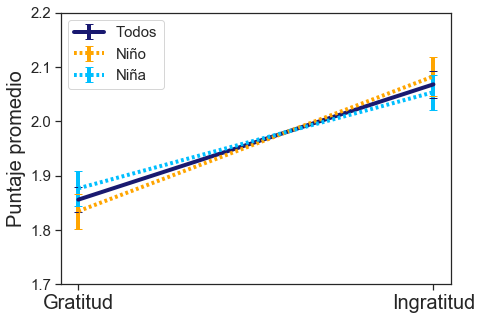

In [304]:
OROS_GRAT_MEDIAS = [np.nanmean(OROS_GRAT1_ih), np.nanmean(OROS_INGRAT1_ih)]
OROS_GRAT_SEM = [stats.sem(OROS_GRAT1_ih, nan_policy = 'omit'), stats.sem(OROS_INGRAT1_ih, nan_policy = 'omit')]

#Niño
OROS_GRAT_MEDIAS_niño = [np.nanmean(niño_agradecido_oros), np.nanmean(niño_desagradecido_oros)]
OROS_GRAT_SEM_niño = [stats.sem(niño_agradecido_oros, nan_policy = 'omit'), stats.sem(niño_desagradecido_oros, nan_policy = 'omit')]

#Niña
OROS_GRAT_MEDIAS_niña = [np.nanmean(niña_agradecido_oros), np.nanmean(niña_desagradecido_oros)]
OROS_GRAT_SEM_niña = [stats.sem(niña_agradecido_oros, nan_policy = 'omit'), stats.sem(niña_agradecido_oros, nan_policy = 'omit')]

label = ['Gratitud', 'Ingratitud']


plt.figure(figsize = (7,5))
plt.errorbar(label, OROS_GRAT_MEDIAS, OROS_GRAT_SEM, color='midnightblue', linewidth=4, capsize =4, label = 'Todos')
plt.errorbar(label, OROS_GRAT_MEDIAS_niño, OROS_GRAT_SEM_niño, color='orange', dashes = [0.7, 0.7], linewidth=4, capsize =4, label = 'Niño')
plt.errorbar(label, OROS_GRAT_MEDIAS_niña, OROS_GRAT_SEM_niña, color='deepskyblue', dashes = [0.7, 0.7], linewidth=4, capsize =4, label = 'Niña')

plt.xticks(rotation=0, size=20)
plt.yticks(size=15)
plt.ylim(1.7,2.2)
plt.ylabel('Puntaje promedio', size = 20)
plt.legend(loc='upper left', prop={'size': 15})
# plt.grid(True, linewidth=0.5, color='k', linestyle='-')


<a id ='oros_ep'></a>

# ESCALA DE EMOCIONES POSITIVAS DE OROS

<a href='#top2'> SUBIR A DESCRIPTIVOS </a>

<a href='#oros_ep_anova'> ANOVA </a>

<a href='#oros_ep_plot'> GRÁFICO </a>

Descriptivos a nivel general: 

Media

Desviación Estandar

Intervalo de confianza del 95%

In [526]:
print('OROS emoción = ', 'Media: ', np.nanmean(OROS_EP_EMOCION), '| SD: ', stats.sem(OROS_EP_EMOCION,0, nan_policy = 'omit'), '| 95%CI: ', ci951(OROS_EP_EMOCION))
print()
print('OROS serenidad = ', 'Media: ', np.nanmean(OROS_EP_SERENIDAD), '| SD: ', stats.sem(OROS_EP_SERENIDAD, nan_policy = 'omit'), '| 95%CI: ', ci951(OROS_EP_SERENIDAD))
print()
print('OROS simpatía = ', 'Media: ', np.nanmean(OROS_EP_SIMPATIA), '| SD: ', stats.sem(OROS_EP_SIMPATIA, nan_policy = 'omit'), '| 95%CI: ', ci951(OROS_EP_SIMPATIA))
print()
print('OROS Satisfacción personal = ', 'Media: ', np.nanmean(OROS_EP_SAT_PERS), '| SD: ', stats.sem(OROS_EP_SAT_PERS, nan_policy = 'omit'), '| 95%CI: ', ci951(OROS_EP_SAT_PERS))

OROS emoción =  Media:  1.2626198083067093 | SD:  [0.026955826023774675 0.01750659990353687 0.021615877964491298
 0.030710410537300115 0.03613064358382898] | 95%CI:  [1.2080493475693226, 1.317190269044096]

OROS serenidad =  Media:  1.750266240681576 | SD:  [0.0363823966772218 0.03604724274975936 0.03669577366770971
 0.0362770355062524 0.03712829602940647 0.040736631304519405] | 95%CI:  [1.6783197593293846, 1.8222127220337676]

OROS simpatía =  Media:  1.6621405750798721 | SD:  [0.03595000058104789 0.04378966632597699 0.03455894612313358
 0.03613064358382898] | 95%CI:  [1.5796756119099855, 1.7446055382497587]

OROS Satisfacción personal =  Media:  1.3535676251331203 | SD:  [0.02762120610302628 0.03581688911778449 0.03625087298641295] | 95%CI:  [1.2885660577719416, 1.4185691924942991]


.

Divido la base por sexo para ver explorar si hay diferencias por sexo

In [530]:
OROS_EP_base_sexo = []
for sexo, oros_ep_sex in OROS_EP.groupby('Sexo'):
    
    OROS_EP_EMOCION_sex = np.concatenate([oros_ep_sex['OROS_EP_1'],oros_ep_sex['OROS_EP_2'],oros_ep_sex['OROS_EP_4'],oros_ep_sex['OROS_EP_10'],oros_ep_sex['OROS_EP_21']])
    OROS_EP_SERENIDAD_sex = np.concatenate([oros_ep_sex['OROS_EP_3'], oros_ep_sex['OROS_EP_5'],oros_ep_sex['OROS_EP_9'],oros_ep_sex['OROS_EP_14'],oros_ep_sex['OROS_EP_17'],oros_ep_sex['OROS_EP_19']])
    OROS_EP_SIMPATIA_sex = np.concatenate([oros_ep_sex['OROS_EP_6'], oros_ep_sex['OROS_EP_7'],oros_ep_sex['OROS_EP_11'],oros_ep_sex['OROS_EP_21']])
    OROS_EP_SAT_PERS_sex = np.concatenate([oros_ep_sex['OROS_EP_8'],oros_ep_sex['OROS_EP_16'],oros_ep_sex['OROS_EP_20']])
    
    OROS_EP_base_sexo.append([OROS_EP_EMOCION_sex, OROS_EP_SERENIDAD_sex, OROS_EP_SIMPATIA_sex, OROS_EP_SAT_PERS_sex])  
    print(sexo)


1.0
2.0


In [389]:
niño_OROS_emocion = OROS_EP_base_sexo[0][0]
niño_OROS_serenidad = OROS_EP_base_sexo[0][1]
niño_OROS_simpatia = OROS_EP_base_sexo[0][2]
niño_OROS_sat_pers = OROS_EP_base_sexo[0][3]

niña_OROS_emocion = OROS_EP_base_sexo[1][0]
niña_OROS_serenidad = OROS_EP_base_sexo[1][1]
niña_OROS_simpatia = OROS_EP_base_sexo[1][2]
niña_OROS_sat_pers = OROS_EP_base_sexo[1][3]

Descriptivo SEXO

Niño

In [390]:
print('OROS emoción = ', 'Media: ', np.nanmean(niño_OROS_emocion), '| SD: ', stats.sem(niño_OROS_emocion, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_OROS_emocion))
print()
print('OROS serenidad = ', 'Media: ', np.nanmean(niño_OROS_serenidad), '| SD: ', stats.sem(niño_OROS_serenidad, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_OROS_serenidad))
print()
print('OROS simpatía = ', 'Media: ', np.nanmean(niño_OROS_simpatia), '| SD: ', stats.sem(niño_OROS_simpatia, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_OROS_simpatia))
print()
print('OROS satisfacción personal = ', 'Media: ', np.nanmean(niño_OROS_sat_pers), '| SD: ', stats.sem(niño_OROS_sat_pers, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_OROS_sat_pers))


OROS emoción =  Media:  1.25625 | SD:  0.01753187469048029 | 95%CI:  [1.2225353409041142, 1.289964659095886]

OROS serenidad =  Media:  1.7916666666666667 | SD:  0.021569794940140333 | 95%CI:  [1.750182561927547, 1.8331507714057864]

OROS simpatía =  Media:  1.6296875 | SD:  0.029138817082112918 | 95%CI:  [1.5736608858040781, 1.6857141141959218]

OROS satisfacción personal =  Media:  1.3791666666666667 | SD:  0.028211571638218007 | 95%CI:  [1.324937062102778, 1.4333962712305552]


Niña

In [391]:
print('OROS emoción = ', 'Media: ', np.nanmean(niña_OROS_emocion), '| SD: ', stats.sem(niña_OROS_emocion, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_OROS_emocion))
print()
print('OROS serenidad = ', 'Media: ', np.nanmean(niña_OROS_serenidad), '| SD: ', stats.sem(niña_OROS_serenidad, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_OROS_serenidad))
print()
print('OROS simpatía = ', 'Media: ', np.nanmean(niña_OROS_simpatia), '| SD: ', stats.sem(niña_OROS_simpatia, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_OROS_simpatia))
print()
print('OROS satisfacción personal = ', 'Media: ', np.nanmean(niña_OROS_sat_pers), '| SD: ', stats.sem(niña_OROS_sat_pers, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_OROS_sat_pers))


OROS emoción =  Media:  1.269281045751634 | SD:  0.01833728082181775 | 95%CI:  [1.2339363586802885, 1.3046257328229793]

OROS serenidad =  Media:  1.7069716775599129 | SD:  0.02147375459787631 | 95%CI:  [1.665576995028251, 1.7483663600915746]

OROS simpatía =  Media:  1.696078431372549 | SD:  0.031433563626343045 | 95%CI:  [1.6355008740606563, 1.7566559886844417]

OROS satisfacción personal =  Media:  1.326797385620915 | SD:  0.02679916068904604 | 95%CI:  [1.275165161610047, 1.378429609631783]


_____________

In [503]:
niño_emocion_oros_b = pd.DataFrame(OROS_EP_base_sexo[0][0], columns = ['Gratitud'])
niño_emocion_oros_b['Sexo'] = 'Niño'
niño_emocion_oros_b['GRAT'] = 'Emoción'


niño_serenidad_oros_b = pd.DataFrame(OROS_EP_base_sexo[0][1], columns = ['Gratitud'])
niño_serenidad_oros_b['Sexo'] = 'Niño'
niño_serenidad_oros_b['GRAT'] = 'Serenidad'


niño_simpatia_oros_b = pd.DataFrame(OROS_EP_base_sexo[0][2], columns = ['Gratitud'])
niño_simpatia_oros_b['Sexo'] = 'Niño'
niño_simpatia_oros_b['GRAT'] = 'Simpatía'


niño_satpers_oros_b = pd.DataFrame(OROS_EP_base_sexo[0][3], columns = ['Gratitud'])
niño_satpers_oros_b['Sexo'] = 'Niño'
niño_satpers_oros_b['GRAT'] = 'Satisfacción Personal'


niña_emocion_oros_b = pd.DataFrame(OROS_EP_base_sexo[1][0], columns = ['Gratitud'])
niña_emocion_oros_b['Sexo'] = 'Niña'
niña_emocion_oros_b['GRAT'] = 'Emoción'


niña_serenidad_oros_b = pd.DataFrame(OROS_EP_base_sexo[1][1], columns = ['Gratitud'])
niña_serenidad_oros_b['Sexo'] = 'Niña'
niña_serenidad_oros_b['GRAT'] = 'Serenidad'


niña_simpatia_oros_b = pd.DataFrame(OROS_EP_base_sexo[1][2], columns = ['Gratitud'])
niña_simpatia_oros_b['Sexo'] = 'Niña'
niña_simpatia_oros_b['GRAT'] = 'Simpatía'


niña_satpers_oros_b = pd.DataFrame(OROS_EP_base_sexo[1][3], columns = ['Gratitud'])
niña_satpers_oros_b['Sexo'] = 'Niña'
niña_satpers_oros_b['GRAT'] = 'Satisfacción Personal'



GRAT_ep_all = pd.concat([niño_emocion_oros_b, niño_serenidad_oros_b, niño_simpatia_oros_b, niño_satpers_oros_b, niña_emocion_oros_b, niña_serenidad_oros_b, niña_simpatia_oros_b, niña_satpers_oros_b])

<a id ='oros_ep_anova'></a>

ANOVA


Una prueba de hipótesis solo para ver si hay diferencias entre niños y niñas

In [504]:
#ANOVA de dos factores (factor 1 = Sexo: Niño|Niña; factor 2 = subescala: Emoción|Serenidad|Simpatía|Satisfacción personal)

# GRAT_all
res = stat()
res.levene(df=GRAT_ep_all.dropna(), res_var='Gratitud', xfac_var=['Sexo','GRAT'])
res.levene_summary

#Verificar si se cumple la supisición de varianzas iguales

if res.levene_summary['Value'][2] < 0.05: 
    print('p-value: ', res.levene_summary['Value'][2],'|', 'Se asumen varianzanzas Desiguales')
else: 
    print('p-value: ', res.levene_summary['Value'][2], '|', 'No se asumen varianzas iguales')

p-value:  0.0 | Se asumen varianzanzas Desiguales


In [505]:
res.levene_summary

,Parameter,Value
0,Test statistics (W),62.0725
1,Degrees of freedom (Df),7.0000
2,p value,0.0000


Hay que buscar una versión no paramétrica para el análisis

In [506]:
#perform two-way ANOVA

formula = 'Gratitud ~ Sexo + GRAT + Sexo:GRAT'
#formula = 'IndiceEficiencia ~  rango_edad'

model = sm.formula.ols(formula, data= GRAT_ep_all).fit()
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
model.summary()
# Perform ANOVA and print table
# aov_table = sm.stats.anova_lm(model, typ=2)
# print(aov_table)

Overall model F( 7, 5626) =  92.292, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Gratitud   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     92.29
Date:                Mon, 07 Jun 2021   Prob (F-statistic):          6.87e-128
Time:                        11:43:06   Log-Likelihood:                -5421.3
No. Observations:                5634   AIC:                         1.086e+04
Df Residuals:                    5626   BIC:                         1.091e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      1.2693      0.023     55.388      0.000       1.224       1.314
Sexo[T.Niño]                                  -0.0130      0.032     -0.407      0.684      -0.076       0.050
GRAT[T.Satisfacción Personal]                  0.0575      0.037      1.537      0.124      -0.016       0.131
GRAT[T.Serenidad]                              0.4377      0.031     14.106      0.000       0.377       0.499
GRAT[T.Simpatía]                               0.4268      0.034     12.416      0.000       0.359       0.494
Sexo[T.Niño]:GRAT[T.Satisfacción Personal]     0.0654      0.052      1.250      0.212      -0.037       0.168
Sexo[T.Niño]:GRAT[T.Serenidad]                 0.0977      0.043      2.252      0.024       0.013       0.183
Sexo[T.Niño]:GRAT[T.Simpatía]                 -0.0534      0.048     -1.110      0.267      -0.148       0.041
==============================================================================
Omnibus:                      483.803   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.081
Skew:                           0.809   Prob(JB):                    1.01e-134
Kurtosis:                       2.883   Cond. No.                         12.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [471]:
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Sexo,4.729857,1.0,4.729857,2.989467,0.083844,0.000253,0.000168
GRAT,5175.153659,4.0,1293.788415,817.728235,0.000000,0.276706,0.276345
Sexo:GRAT,17.367341,4.0,4.341835,2.744221,0.026891,0.000929,0.000590
Residual,13505.437920,8536.0,1.582174,NaN,NaN,NaN,NaN


POST HOC

In [399]:
pair_t = model.t_test_pairwise('GRAT')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Satisfacción Personal-Emoción,0.057516,0.037422,1.536971,1.243568e-01,-0.015845,0.130878,0.233249,False
Serenidad-Emoción,0.437691,0.031029,14.106043,1.978757e-44,0.376863,0.498519,0.000000,True
Simpatía-Emoción,0.426797,0.034374,12.416213,6.102964e-35,0.359411,0.494184,0.000000,True
Serenidad-Satisfacción Personal,0.380174,0.036234,10.492317,1.609979e-25,0.309142,0.451206,0.000000,True
Simpatía-Satisfacción Personal,0.369281,0.039137,9.435660,5.548880e-21,0.292558,0.446004,0.000000,True
Simpatía-Serenidad,-0.010893,0.033077,-0.329334,7.419155e-01,-0.075736,0.053950,0.741915,False


<a id ='oros_ep_plot'></a>

______

GRÁFICO

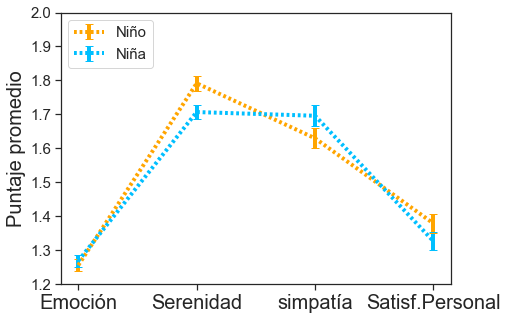

In [409]:
OROS_EP_MEDIAS = [np.nanmean(OROS_EP_EMOCION), np.nanmean(OROS_EP_SIMPATIA), np.nanmean(OROS_EP_SERENIDAD), np.nanmean(OROS_EP_SAT_PERS)]
OROS_EP_SEM = [stats.sem(OROS_EP_EMOCION, nan_policy = 'omit'), stats.sem(OROS_EP_SIMPATIA, nan_policy = 'omit'), stats.sem(OROS_EP_SERENIDAD, nan_policy = 'omit'), stats.sem(OROS_EP_SAT_PERS, nan_policy = 'omit')]

#Niño
OROS_EP_MEDIAS_niño = [np.nanmean(OROS_EP_base_sexo[0][0]), np.nanmean(OROS_EP_base_sexo[0][1]), np.nanmean(OROS_EP_base_sexo[0][2]), np.nanmean(OROS_EP_base_sexo[0][3])]
OROS_EP_SEM_niño = [stats.sem(OROS_EP_base_sexo[0][0], nan_policy = 'omit'), stats.sem(OROS_EP_base_sexo[0][1], nan_policy = 'omit'), stats.sem(OROS_EP_base_sexo[0][2], nan_policy = 'omit'), stats.sem(OROS_EP_base_sexo[0][3], nan_policy = 'omit')]

#Niña
OROS_EP_MEDIAS_niña = [np.nanmean(OROS_EP_base_sexo[1][0]), np.nanmean(OROS_EP_base_sexo[1][1]), np.nanmean(OROS_EP_base_sexo[1][2]), np.nanmean(OROS_EP_base_sexo[1][3])]
OROS_EP_SEM_niña = [stats.sem(OROS_EP_base_sexo[1][0], nan_policy = 'omit'), stats.sem(OROS_EP_base_sexo[1][1], nan_policy = 'omit'), stats.sem(OROS_EP_base_sexo[1][2], nan_policy = 'omit'), stats.sem(OROS_EP_base_sexo[1][3], nan_policy = 'omit')]

label = ['Emoción', 'Serenidad', 'simpatía', 'Satisf.Personal']


plt.figure(figsize = (7,5))
# plt.errorbar(label, OROS_EP_MEDIAS, OROS_EP_SEM, color='midnightblue', linewidth=4, capsize =4, label = 'Todos')
plt.errorbar(label, OROS_EP_MEDIAS_niño, OROS_EP_SEM_niño, color='orange', dashes = [0.7, 0.7], linewidth=4, capsize =4, label = 'Niño')
plt.errorbar(label, OROS_EP_MEDIAS_niña, OROS_EP_SEM_niña, color='deepskyblue', dashes = [0.7, 0.7], linewidth=4, capsize =4, label = 'Niña')

plt.xticks(rotation=0, size=20)
plt.yticks(size=15)
plt.ylim(1.2,2)
plt.ylabel('Puntaje promedio', size = 20)
plt.legend(loc='upper left', prop={'size': 15})
# plt.grid(True, linewidth=0.5, color='k', linestyle='-')


<a id ='MCGM'></a>

# ANÁLISIS MCGM

<a href='#top2'> SUBIR A DESCRIPTIVOS </a>


<a href='#mcgm_anova'> ANOVA </a>


<a href='#mcgm_plot'> PLOT </a>


Descriptivos a nivel general: 

Media

Desviación Estandar

Intervalo de confianza del 95%

In [461]:
print('MCGM_F1F2 = ', 'Media: ', np.nanmean(MCGM_F1F2), '| SD: ', stats.sem(MCGM_F1F2, nan_policy = 'omit'), '| 95%CI: ', ci951(MCGM_F1F2))
print()
print('MCGM_F3 = ', 'Media: ', np.nanmean(MCGM_F3), '| SD: ', stats.sem(MCGM_F3, nan_policy = 'omit'), '| 95%CI: ', ci951(MCGM_F3))
print()
print('MCGM_F4 = ', 'Media: ', np.nanmean(MCGM_F4), '| SD: ', stats.sem(MCGM_F4, nan_policy = 'omit'), '| 95%CI: ', ci951(MCGM_F4))
print()
print('MCGM_F5 = ', 'Media: ', np.nanmean(MCGM_F5), '| SD: ', stats.sem(MCGM_F5, nan_policy = 'omit'), '| 95%CI: ', ci951(MCGM_F5))
print()
print('MCGM_F6 = ', 'Media: ', np.nanmean(MCGM_F6), '| SD: ', stats.sem(MCGM_F6, nan_policy = 'omit'), '| 95%CI: ', ci951(MCGM_F6))

MCGM_F1F2 =  Media:  4.25716084356311 | SD:  [0.027812262269327277 0.05027689138640041 0.04322712276488418
 0.04402262572388851 0.05214628067688227 0.048218492742785134
 0.046539527300683524 0.04275612208833835 0.04841012382720128
 0.04381612064019824] | 95%CI:  [4.122776626921753, 4.391545060204467]

MCGM_F3 =  Media:  3.0235725510738605 | SD:  [0.027812262269327277 0.08635693410859673 0.08227807162115414
 0.08669323215073799 0.08999656308375374 0.08998746471006787] | 95%CI:  [2.849619707072668, 3.197525395075053]

MCGM_F4 =  Media:  2.1278337531486144 | SD:  [0.027812262269327277 0.0760854968488932 0.07848453685528725
 0.0786431643943824 0.08165401890448788] | 95%CI:  [1.9853494922329515, 2.2703180140642774]

MCGM_F5 =  Media:  3.10031512605042 | SD:  [0.027812262269327277 0.08314179007607024 0.0821833734174278
 0.07874497050089801 0.07533236755379101 0.07856328366507814] | 95%CI:  [2.9367181746370528, 3.2639120774637873]

MCGM_F6 =  Media:  3.5516372795969775 | SD:  [0.0278122622693

Divido la base por sexo para ver explorar si hay diferencias por sexo

In [462]:
mcgm_sexo = []
for sexo, mcgm_sex in MCGM.groupby('Sexo'):
    
    mcgm_f1f2_sex = np.concatenate([mcgm_sex['MCGM_1'],mcgm_sex['MCGM_2'],mcgm_sex['MCGM_3'], mcgm_sex['MCGM_4'],mcgm_sex['MCGM_5'],
                                    mcgm_sex['MCGM_6'],mcgm_sex['MCGM_8'], mcgm_sex['MCGM_9'],mcgm_sex['MCGM_10']])
    mcgm_f3_sex = np.concatenate([mcgm_sex['MCGM_11'], mcgm_sex['MCGM_12'], mcgm_sex['MCGM_13'],mcgm_sex['MCGM_14'],mcgm_sex['MCGM_15']])
    mcgm_f4_sex = np.concatenate([mcgm_sex['MCGM_17'], mcgm_sex['MCGM_18'],mcgm_sex['MCGM_19'],mcgm_sex['MCGM_20']])
    mcgm_f5_sex = np.concatenate([mcgm_sex['MCGM_21'],mcgm_sex['MCGM_22'],mcgm_sex['MCGM_23'], mcgm_sex['MCGM_24'], mcgm_sex['MCGM_25']])
    mcgm_f6_sex = np.concatenate([mcgm_sex['MCGM_26'],mcgm_sex['MCGM_27'],mcgm_sex['MCGM_28'], mcgm_sex['MCGM_29']])

        
    mcgm_sexo.append([mcgm_f1f2_sex, mcgm_f3_sex, mcgm_f4_sex, mcgm_f5_sex, mcgm_f6_sex])  
    print(sexo)


niño_mcgmf1f2 = mcgm_sexo[0][0]
niño_mcgmf3 = mcgm_sexo[0][1]
niño_mcgmf4 = mcgm_sexo[0][2]
niño_mcgmf5 = mcgm_sexo[0][3]
niño_mcgmf6 = mcgm_sexo[0][4]

niña_mcgmf1f2 = mcgm_sexo[1][0]
niña_mcgmf3 = mcgm_sexo[1][1]
niña_mcgmf4 = mcgm_sexo[1][2]
niña_mcgmf5 = mcgm_sexo[1][3]
niña_mcgmf6 = mcgm_sexo[1][4]


1.0
2.0


Descriptivo SEXO

Niño

In [463]:
print('MCGM F1F2 = ', 'Media: ', np.nanmean(niño_mcgmf1f2), '| SD: ', stats.sem(niño_mcgmf1f2, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_mcgmf1f2))
print()
print('MCGM F3 = ', 'Media: ', np.nanmean(niño_mcgmf3), '| SD: ', stats.sem(niño_mcgmf3, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_mcgmf3))
print()
print('MCGM F4 = ', 'Media: ', np.nanmean(niño_mcgmf4), '| SD: ', stats.sem(niño_mcgmf4, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_mcgmf4))
print()
print('MCGM F5 = ', 'Media: ', np.nanmean(niño_mcgmf5), '| SD: ', stats.sem(niño_mcgmf5, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_mcgmf5))
print()
print('MCGM F6 = ', 'Media: ', np.nanmean(niño_mcgmf6), '| SD: ', stats.sem(niño_mcgmf6, nan_policy = 'omit'), '| 95%CI: ', ci951(niño_mcgmf6))



MCGM F1F2 =  Media:  4.585048010973937 | SD:  0.02201914169833807 | 95%CI:  [4.542428257355995, 4.6276677645918785]

MCGM F3 =  Media:  3.365432098765432 | SD:  0.05381608785094161 | 95%CI:  [3.261295495049196, 3.469568702481668]

MCGM F4 =  Media:  2.2098765432098766 | SD:  0.05362115698539366 | 95%CI:  [2.1061331729637622, 2.313619913455991]

MCGM F5 =  Media:  3.3740740740740742 | SD:  0.04986905522139215 | 95%CI:  [3.2775751599263723, 3.470572988221776]

MCGM F6 =  Media:  4.013888888888889 | SD:  0.051935899576456446 | 95%CI:  [3.9134060652845233, 4.114371712493256]


Niña

In [464]:

print('MCGM F1F2  = ', 'Media: ', np.nanmean(niña_mcgmf1f2), '| SD: ', stats.sem(niña_mcgmf1f2, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_mcgmf1f2))
print()
print('MCGM F3 = ', 'Media: ', np.nanmean(niña_mcgmf3), '| SD: ', stats.sem(niña_mcgmf3, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_mcgmf3))
print()
print('MCGM F4 = ', 'Media: ', np.nanmean(niña_mcgmf4), '| SD: ', stats.sem(niña_mcgmf4, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_mcgmf4))
print()
print('MCGM f5 = ', 'Media: ', np.nanmean(niña_mcgmf5), '| SD: ', stats.sem(niña_mcgmf5, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_mcgmf5))
print()
print('MCGM F6 = ', 'Media: ', np.nanmean(niña_mcgmf6), '| SD: ', stats.sem(niña_mcgmf6, nan_policy = 'omit'), '| 95%CI: ', ci951(niña_mcgmf6))



MCGM F1F2  =  Media:  4.557706093189964 | SD:  0.022219833381683863 | 95%CI:  [4.514586122393853, 4.600826063986075]

MCGM F3 =  Media:  3.3083870967741937 | SD:  0.05732638181179052 | 95%CI:  [3.197171028457061, 3.4196031650913263]

MCGM F4 =  Media:  2.3782467532467533 | SD:  0.057599273822486696 | 95%CI:  [2.266880887331212, 2.4896126191622945]

MCGM f5 =  Media:  3.4909090909090907 | SD:  0.05143370927376936 | 95%CI:  [3.3914479260338553, 3.5903702557843262]

MCGM F6 =  Media:  4.150974025974026 | SD:  0.04756113536772482 | 95%CI:  [4.059016494695479, 4.242931557252573]


_____________

In [468]:
niño_mcgm_f1f2 = pd.DataFrame(mcgm_sexo[0][0], columns = ['Gratitud'])
niño_mcgm_f1f2['Sexo'] = 'Niño'
niño_mcgm_f1f2['GRAT'] = 'Emocion|Actitud para gratitud'


niño_mcgm_f3 = pd.DataFrame(mcgm_sexo[0][1], columns = ['Gratitud'])
niño_mcgm_f3['Sexo'] = 'Niño'
niño_mcgm_f3['GRAT'] = 'Actitudes de oportunidad'


niño_mcgm_f4 = pd.DataFrame(mcgm_sexo[0][2], columns = ['Gratitud'])
niño_mcgm_f4['Sexo'] = 'Niño'
niño_mcgm_f4['GRAT'] = 'Defectos de comportamiento'


niño_mcgm_f5 = pd.DataFrame(mcgm_sexo[0][3], columns = ['Gratitud'])
niño_mcgm_f5['Sexo'] = 'Niño'
niño_mcgm_f5['GRAT'] = 'Rituales/notar beneficios'


niño_mcgm_f6 = pd.DataFrame(mcgm_sexo[0][4], columns = ['Gratitud'])
niño_mcgm_f6['Sexo'] = 'Niño'
niño_mcgm_f6['GRAT'] = 'Expresiones de gratitud'



niña_mcgm_f1f2 = pd.DataFrame(mcgm_sexo[1][0], columns = ['Gratitud'])
niña_mcgm_f1f2['Sexo'] = 'Niña'
niña_mcgm_f1f2['GRAT'] = 'Emocion|Actitud para gratitud'


niña_mcgm_f3 = pd.DataFrame(mcgm_sexo[1][1], columns = ['Gratitud'])
niña_mcgm_f3['Sexo'] = 'Niña'
niña_mcgm_f3['GRAT'] = 'Actitudes de oportunidad'


niña_mcgm_f4 = pd.DataFrame(mcgm_sexo[1][2], columns = ['Gratitud'])
niña_mcgm_f4['Sexo'] = 'Niña'
niña_mcgm_f4['GRAT'] = 'Defectos de comportamiento'


niña_mcgm_f5 = pd.DataFrame(mcgm_sexo[1][3], columns = ['Gratitud'])
niña_mcgm_f5['Sexo'] = 'Niña'
niña_mcgm_f5['GRAT'] = 'Rituales/notar beneficios'

niña_mcgm_f6 = pd.DataFrame(mcgm_sexo[1][4], columns = ['Gratitud'])
niña_mcgm_f6['Sexo'] = 'Niña'
niña_mcgm_f6['GRAT'] = 'Expresiones de gratitud'


GRAT_mcgm_all = pd.concat([niño_mcgm_f1f2, niño_mcgm_f3, niño_mcgm_f4, niño_mcgm_f5, niño_mcgm_f6, niña_mcgm_f1f2, niña_mcgm_f3, niña_mcgm_f4,
                        niña_mcgm_f5, niña_mcgm_f6])

In [707]:
len(GRAT_mcgm_all)

8748

<a id ='mcgm_anova'></a>

ANOVA

In [469]:
#ANOVA de dos factores (factor 1 = Sexo: Niño|Niña; factor 2 = subescala: Emoción|Serenidad|Simpatía|Satisfacción personal)

# GRAT_all
res = stat()
res.levene(df=GRAT_mcgm_all.dropna(), res_var='Gratitud', xfac_var=['Sexo','GRAT'])
res.levene_summary

#Verificar si se cumple la supisición de varianzas iguales

if res.levene_summary['Value'][2] < 0.05: 
    print('p-value: ', res.levene_summary['Value'][2],'|', 'Se asumen varianzanzas Desiguales')
else: 
    print('p-value: ', res.levene_summary['Value'][2], '|', 'No se asumen varianzas iguales')

p-value:  0.0 | Se asumen varianzanzas Desiguales


In [708]:
#perform two-way ANOVA

formula = 'Gratitud ~ Sexo + GRAT'
#formula = 'IndiceEficiencia ~  rango_edad'

model = sm.formula.ols(formula, data= GRAT_ep_all).fit()
# Perform ANOVA and print table
aov_table = sm.stats.anova_lm(model, typ=2)
# print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
model.summary()

# print(aov_table)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Gratitud   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     158.2
Date:                Mon, 07 Jun 2021   Prob (F-statistic):          1.85e-128
Time:                        20:06:11   Log-Likelihood:                -5427.5
No. Observations:                5634   AIC:                         1.087e+04
Df Residuals:                    5629   BIC:                         1.090e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.2531      0.018     68.792      0.000       1.217       1.289
Sexo[T.Niño]                      0.0186      0.017      1.099      0.272      -0.015       0.052
GRAT[T.Satisfacción Personal]     0.0909      0.026      3.473      0.001       0.040       0.142
GRAT[T.Serenidad]                 0.4876      0.022     22.460      0.000       0.445       0.530
GRAT[T.Simpatía]                  0.3995      0.024     16.610      0.000       0.352       0.447
==============================================================================
Omnibus:                      487.050   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              622.253
Skew:                           0.812   Prob(JB):                    7.58e-136
Kurtosis:                       2.883   Cond. No.                         5.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [472]:
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Sexo,4.729857,1.0,4.729857,2.989467,0.083844,0.000253,0.000168
GRAT,5175.153659,4.0,1293.788415,817.728235,0.000000,0.276706,0.276345
Sexo:GRAT,17.367341,4.0,4.341835,2.744221,0.026891,0.000929,0.000590
Residual,13505.437920,8536.0,1.582174,NaN,NaN,NaN,NaN


POST HOC

In [473]:
pair_t = model.t_test_pairwise('GRAT')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Defectos de comportamiento-Actitudes de oportunidad,-0.930140,0.067897,-13.699319,2.863377e-42,-1.063235,-0.797046,0.000000e+00,True
Emocion|Actitud para gratitud-Actitudes de oportunidad,1.249319,0.056353,22.169418,6.348144e-106,1.138853,1.359785,0.000000e+00,True
Expresiones de gratitud-Actitudes de oportunidad,0.842587,0.067897,12.409813,4.633768e-35,0.709493,0.975681,0.000000e+00,True
Rituales/notar beneficios-Actitudes de oportunidad,0.182522,0.064002,2.851806,4.357594e-03,0.057062,0.307982,4.357594e-03,True
Emocion|Actitud para gratitud-Defectos de comportamiento,2.179459,0.060849,35.817318,7.099740e-262,2.060180,2.298739,0.000000e+00,True
Expresiones de gratitud-Defectos de comportamiento,1.772727,0.071672,24.733761,1.681061e-130,1.632232,1.913222,0.000000e+00,True
Rituales/notar beneficios-Defectos de comportamiento,1.112662,0.067994,16.364033,2.745007e-59,0.979377,1.245948,0.000000e+00,True
Expresiones de gratitud-Emocion|Actitud para gratitud,-0.406732,0.060849,-6.684250,2.466715e-11,-0.526011,-0.287453,4.933431e-11,True
Rituales/notar beneficios-Emocion|Actitud para gratitud,-1.066797,0.056471,-18.891140,5.188799e-78,-1.177493,-0.956101,0.000000e+00,True
Rituales/notar beneficios-Expresiones de gratitud,-0.660065,0.067994,-9.707639,3.641360e-22,-0.793350,-0.526779,0.000000e+00,True


In [487]:
stats.sem(np.nanmean(MCGM_F1F2,0), nan_policy = 'omit')

0.30974143926753356

<a id ='mcgm_plot'></a>

MCGM PLOT

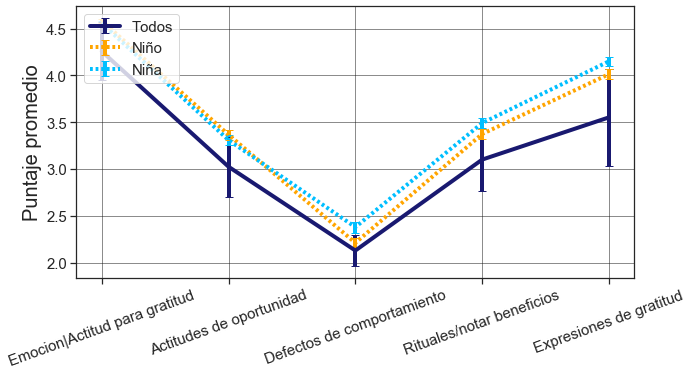

In [494]:
mcgm_MEDIAS = [np.nanmean(MCGM_F1F2), np.nanmean(MCGM_F3), np.nanmean(MCGM_F4), np.nanmean(MCGM_F5), np.nanmean(MCGM_F6)]
mcgm_SEM = [stats.sem(np.nanmean(MCGM_F1F2,0), nan_policy = 'omit'), stats.sem(np.nanmean(MCGM_F3,0), nan_policy = 'omit'), 
            stats.sem(np.nanmean(MCGM_F4,0), nan_policy = 'omit'), stats.sem(np.nanmean(MCGM_F5,0), nan_policy = 'omit'), stats.sem(np.nanmean(MCGM_F6,0), nan_policy = 'omit')]

#Niño
mcgm_MEDIAS_niño = [np.nanmean(mcgm_sexo[0][0]), np.nanmean(mcgm_sexo[0][1]), np.nanmean(mcgm_sexo[0][2]), np.nanmean(mcgm_sexo[0][3]), np.nanmean(mcgm_sexo[0][4])]
mcgm_SEM_niño = [stats.sem(mcgm_sexo[0][0], nan_policy = 'omit'), stats.sem(mcgm_sexo[0][1], nan_policy = 'omit'), stats.sem(mcgm_sexo[0][2], nan_policy = 'omit'),
                 stats.sem(mcgm_sexo[0][3], nan_policy = 'omit'), stats.sem(mcgm_sexo[0][4], nan_policy = 'omit')]

#Niña
mcgm_MEDIAS_niña = [np.nanmean(mcgm_sexo[1][0]), np.nanmean(mcgm_sexo[1][1]), np.nanmean(mcgm_sexo[1][2]), np.nanmean(mcgm_sexo[1][3]), np.nanmean(mcgm_sexo[1][4])]
mcgm_SEM_niña = [stats.sem(mcgm_sexo[1][0], nan_policy = 'omit'), stats.sem(mcgm_sexo[1][1], nan_policy = 'omit'), stats.sem(mcgm_sexo[1][2], nan_policy = 'omit'),
                 stats.sem(mcgm_sexo[1][3], nan_policy = 'omit'), stats.sem(mcgm_sexo[1][4], nan_policy = 'omit')]

label = ['Emocion|Actitud para gratitud', 'Actitudes de oportunidad', 'Defectos de comportamiento', 'Rituales/notar beneficios', 'Expresiones de gratitud']


plt.figure(figsize = (10,5))
plt.errorbar(label, mcgm_MEDIAS, mcgm_SEM, color='midnightblue', linewidth=4, capsize =4, label = 'Todos')
plt.errorbar(label, mcgm_MEDIAS_niño, mcgm_SEM_niño, color='orange', dashes = [0.7, 0.7], linewidth=4, capsize =4, label = 'Niño')
plt.errorbar(label, mcgm_MEDIAS_niña, mcgm_SEM_niña, color='deepskyblue', dashes = [0.7, 0.7], linewidth=4, capsize =4, label = 'Niña')

plt.xticks(rotation=20, size=15)
plt.yticks(size=15)
plt.ylabel('Puntaje promedio', size = 20)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(True, linewidth=0.5, color='k', linestyle='-')

<a id ='Analisis entre pruebas'></a>

-------

-------

# As Morgan and collaborators (2017) we aimed to explore whether certain combinations of components would result in particular patterns of gratitude. 

Would an individual who scores highly on all five components of the MCGM report a different level of gratitude to those
that score high on only one, two or three components?   

Vamos a correr los análisis agrupando el MCGM de la siguiente manera: 

-1) Cinco componentes que calculamos del análisis factorial exploratorio. 


-2) Tres componentes principales en donde se engloban las subescalas. (opcional)

<a href='#descriptivos'> Ir a estadísticos descriptivos </a>


<a href='#Ir a inicio'> Ir a inicio </a>

__________

In [542]:
# MCGM.drop(['Sexo'],axis=1,inplace=True)
# OROS_GRAT_ns = OROS_GRAT.drop(['Sexo'],axis=1,inplace=True)
# OROS_EP_ns = OROS_EP.drop(['Sexo'],axis=1,inplace=True)

# Cronbach Alpha

(1)

A nivel general:

In [540]:
print('MCGM: ', cronbach_alpha(MCGM))
print()
print('OROS Gratitud: ', cronbach_alpha(OROS_GRAT))
print()
print('OROS Emociones postitivas: ', cronbach_alpha(OROS_EP))

MCGM:  0.8696875467709008

OROS Gratitud:  0.4672974103825842

OROS Emociones postitivas:  0.8811571212289274


(2)

Dividido por subescalas: 

In [572]:
print('MCGM','\n\n\nFeelings|attitudes of gratitude: ', cronbach_alpha(MCGM_F1F2),'\n\nAttitudes to appropriateness: ', cronbach_alpha(MCGM_F3),
     '\n\nBehavioral shortcomings: ', cronbach_alpha(MCGM_F4), '\n\nRituals/noticing benefits: ', cronbach_alpha(MCGM_F5),
     '\n\nExpressions of gratitude: ', cronbach_alpha(MCGM_F6), '\n\n', '\n\nEmotion/attitude:', cronbach_alpha(MCGM_emocion_actitudes),
     '\n\nAttitudes:', cronbach_alpha(MCGM_actitudes), '\n\nBehaviour:', cronbach_alpha(MCGM_comportamiento))
print('\n')
print('OROS Gratitud','\n\n\nGratitud:', cronbach_alpha(OROS_GRAT1), '\n\nIngratitud:', cronbach_alpha(OROS_INGRAT) )
print('\n')
print('OROS Emociones postitivas', '\n\n\nEmoción:', cronbach_alpha(OROS_EP_EMOCION), '\n\nSerenidad:', cronbach_alpha(OROS_EP_SERENIDAD),
     '\n\nSimpatía:', cronbach_alpha(OROS_EP_SIMPATIA), '\n\nSatisfacción personal:', cronbach_alpha(OROS_EP_SAT_PERS))

MCGM 


Feelings|attitudes of gratitude:  0.9217986246382704 

Attitudes to appropriateness:  0.7031978956218375 

Behavioral shortcomings:  0.7758480592619799 

Rituals/noticing benefits:  0.8307640399090057 

Expressions of gratitude:  0.8575831838227751 

 

Emotion/attitude: 0.9217986246382704 

Attitudes: 0.7031978956218375 

Behaviour: 0.8263653990152614


OROS Gratitud 


Gratitud: 0.1861676377454001 

Ingratitud: 0.1862297489989849


OROS Emociones postitivas 


Emoción: 0.6055375001291118 

Serenidad: 0.7976053504283275 

Simpatía: 0.6278078587505429 

Satisfacción personal: 0.7689672681575958


# Correlaciones 

Concateno los ítems de las subescalas

In [732]:
suma_MCGM_f1f2 = (MCGM['MCGM_1']+MCGM['MCGM_2']+MCGM['MCGM_3']+MCGM['MCGM_4']+MCGM['MCGM_5']+MCGM['MCGM_6']+MCGM['MCGM_8']+MCGM['MCGM_9']+MCGM['MCGM_10'])/9

suma_MCGM_f3 =  (MCGM['MCGM_11'] + MCGM['MCGM_12']+ MCGM['MCGM_13']+ MCGM['MCGM_14']+ MCGM['MCGM_15'])/5

suma_MCGM_f4 =  (MCGM['MCGM_17']+ MCGM['MCGM_18']+ MCGM['MCGM_19']+ MCGM['MCGM_20'])/4

suma_MCGM_f5 =(MCGM['MCGM_21'] + MCGM['MCGM_22']+ MCGM['MCGM_23']+ MCGM['MCGM_24']+ MCGM['MCGM_25'])/5
                            
suma_MCGM_f6 =  (MCGM['MCGM_26']+ MCGM['MCGM_27']+ MCGM['MCGM_28']+ MCGM['MCGM_29'])/4 

suma_MCGM_comportamiento =(MCGM['MCGM_17']+MCGM['MCGM_18']+ MCGM['MCGM_19']+ MCGM['MCGM_20']+ MCGM['MCGM_21']+
                                       MCGM['MCGM_22']+MCGM['MCGM_23']+ MCGM['MCGM_24']+ MCGM['MCGM_25']+ MCGM['MCGM_26'] +MCGM['MCGM_27'] +
                                       MCGM['MCGM_28']+ MCGM['MCGM_29'])/13

#OROS gratitud
suma_OROS_GRAT1_ih = (OROS_GRAT['OROS_GRAT_2'] + OROS_GRAT['OROS_GRAT_3']+ OROS_GRAT['OROS_GRAT_5']+ OROS_GRAT['OROS_GRAT_6']+ OROS_GRAT['OROS_GRAT_10']+ OROS_GRAT['OROS_GRAT_13']+ OROS_GRAT['OROS_GRAT_14'])/7
suma_OROS_INGRAT1_ih =(OROS_GRAT['OROS_GRAT_1']+ OROS_GRAT['OROS_GRAT_7']+ OROS_GRAT['OROS_GRAT_8']+OROS_GRAT['OROS_GRAT_9']+ OROS_GRAT['OROS_GRAT_11']+ OROS_GRAT['OROS_GRAT_12'])/6

#OROS emociones positivas
suma_OROS_EP_EMOCION2 = (OROS_EP['OROS_EP_1']+OROS_EP['OROS_EP_2']+ OROS_EP['OROS_EP_4']+OROS_EP['OROS_EP_10']+ OROS_EP['OROS_EP_21'])/5
suma_OROS_EP_SERENIDAD2 = (OROS_EP['OROS_EP_3']+ OROS_EP['OROS_EP_5']+OROS_EP['OROS_EP_9']+OROS_EP['OROS_EP_14']+ OROS_EP['OROS_EP_17']+ OROS_EP['OROS_EP_19'])/6
suma_OROS_EP_SIMPATIA2 = (OROS_EP['OROS_EP_6']+ OROS_EP['OROS_EP_7']+ OROS_EP['OROS_EP_11']+OROS_EP['OROS_EP_21'])/4
suma_OROS_EP_SAT_PERS2 = (OROS_EP['OROS_EP_8']+OROS_EP['OROS_EP_16']+OROS_EP['OROS_EP_20'])/3


Las uno en una matriz para analizar

In [741]:
pruebas_all = pd.DataFrame([suma_OROS_GRAT1_ih, suma_OROS_INGRAT1_ih, suma_OROS_EP_EMOCION2,suma_OROS_EP_SERENIDAD2, 
               suma_OROS_EP_SIMPATIA2, suma_OROS_EP_SAT_PERS2, suma_MCGM_f1f2, suma_MCGM_f3, suma_MCGM_f4, 
               suma_MCGM_f5, suma_MCGM_f6, suma_MCGM_comportamiento]).T

In [744]:
r_cors = pruebas_all.corr()

In [756]:
mu_all = [np.nanmean(pruebas_all[i]) for i in range(12)]

In [759]:
y = np.random.multivariate_normal(mu_all, r_cors, size=len(pruebas_all))

c:\users\maria\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [762]:
df2 = pd.DataFrame(y)
df2.columns = ['Gratitud','Ingratitud','Emoción','Serenidad', 'Simpatía', 'Sat.Personal', 'Emoci.Act Grat', 'Actitud Grat', 'Defect.Comp', 'Rituales', 'Exp.Grat', 'Comportamiento']


In [768]:
# df2.pairwise_corr(method='spearman',padjust='holm')
df2.rcorr(method='spearman',padjust='holm')

,Gratitud,Ingratitud,Emoción,Serenidad,Simpatía,Sat.Personal,Emoci.Act Grat,Actitud Grat,Defect.Comp,Rituales,Exp.Grat,Comportamiento
Gratitud,-,***,***,,*,,,,,,,
Ingratitud,0.37,-,,,,,**,,,,,
Emoción,0.248,0.04,-,***,***,***,***,,***,***,***,
Serenidad,0.026,0.125,0.436,-,***,,,*,,,,
Simpatía,0.188,-0.034,0.611,0.256,-,,,,*,*,,
Sat.Personal,0.154,0.14,0.306,0.165,0.16,-,***,,,,,
Emoci.Act Grat,-0.036,0.208,-0.286,-0.054,-0.145,-0.263,-,***,,***,***,***
Actitud Grat,-0.055,0.033,-0.086,-0.189,-0.024,-0.097,0.248,-,,**,,
Defect.Comp,0.071,-0.074,0.274,0.157,0.184,0.164,-0.087,-0.079,-,,,***
Rituales,0.058,0.063,-0.285,-0.15,-0.188,-0.115,0.261,0.232,-0.007,-,***,***


Genero la matriz de correlación

[Text(0.5, 0, 'Gratitud'),
 Text(1.5, 0, 'Ingratitud'),
 Text(2.5, 0, 'Emoción'),
 Text(3.5, 0, 'Serenidad'),
 Text(4.5, 0, 'Simpatía'),
 Text(5.5, 0, 'Sat.Personal'),
 Text(6.5, 0, 'Emoci.Act Grat'),
 Text(7.5, 0, 'Actitud Grat'),
 Text(8.5, 0, 'Defect.Comp'),
 Text(9.5, 0, 'Rituales'),
 Text(10.5, 0, 'Exp.Grat'),
 Text(11.5, 0, 'Comportamiento')]

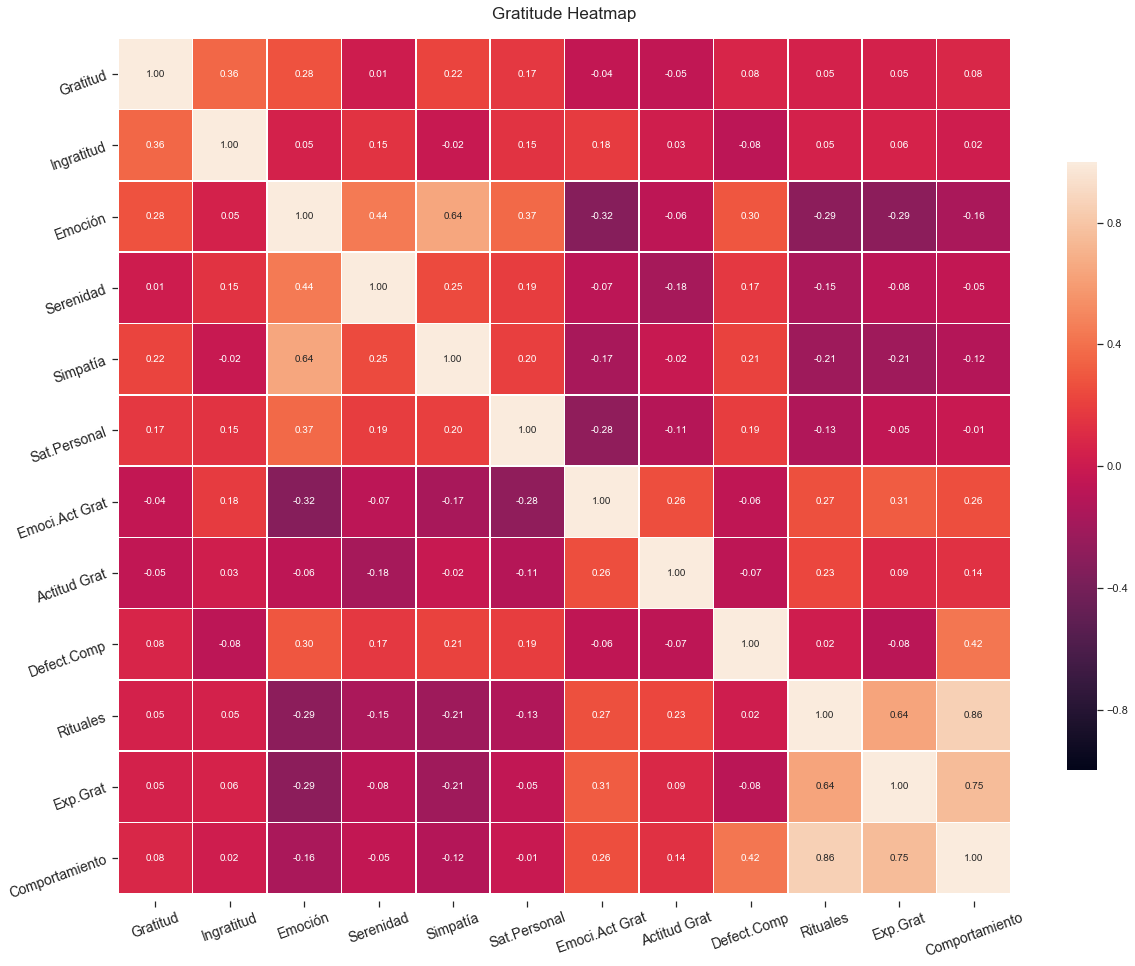

In [765]:
fig, ax = plt.subplots(figsize=(20,16))  

heatmap = sns.heatmap(df2.corr(), vmin=-1, vmax=1, fmt='.2f', cbar_kws={"shrink": .7}, square = False, linewidths=.5, annot=True)
heatmap.set_title('Gratitude Heatmap', fontdict={'fontsize':17}, pad=12)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)

ax.set_yticklabels(labels = ['Gratitud','Ingratitud','Emoción','Serenidad', 'Simpatía', 'Sat.Personal', 'Emoci.Act Grat', 'Actitud Grat', 'Defect.Comp', 'Rituales', 'Exp.Grat', 'Comportamiento'], rotation= 20, size = 14)
ax.set_xticklabels(labels = ['Gratitud','Ingratitud','Emoción','Serenidad', 'Simpatía', 'Sat.Personal', 'Emoci.Act Grat', 'Actitud Grat', 'Defect.Comp', 'Rituales', 'Exp.Grat', 'Comportamiento'], rotation =20, size = 14)


<a href='#Ir a inicio'> Ir a inicio </a>